In [8]:
#Chapter 6. Decision Trees
#Decision trees are versatile machine learning algorithms that can perform both classification and 
#regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting 
#complex datasets. For example, in Chapter 2 you trained a DecisionTreeRegressor model on the 
#California housing dataset, fitting it perfectly (actually, overfitting it).


#Decision trees are also the fundamental components of random forests (see Chapter 7), which are 
#among the most powerful machine learning algorithms available today. In this chapter we will start 
#by discussing how to train, visualize, and make predictions with decision trees. Then we will go 
#through the CART training algorithm used by Scikit-Learn, and we will explore how to regularize 
#trees and use them for regression tasks. Finally, we will discuss some of the limitations of decision trees.


#Training and Visualizing a Decision Tree
#To understand decision trees, let’s build one and take a look at how it makes predictions. 
#The following code trains a DecisionTreeClassifier on the iris dataset (see Chapter 4):

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target


tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)


DecisionTreeClassifier(max_depth=2, random_state=42)

In [12]:
#You can visualize the trained decision tree by first using the export_graphviz() function 
#to output a graph definition file called iris_tree.dot:


from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file="iris_tree.dot", feature_names=["petal length (cm)", "petal width (cm)"],
               class_names=iris.target_names, rounded=True, filled=True)

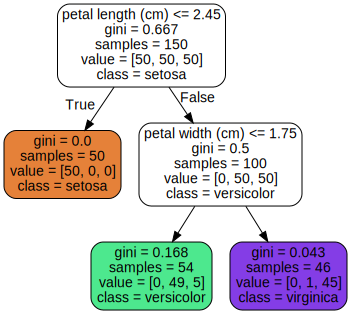

In [13]:
#Then you can use graphviz.Source.from_file() to load and display the file in a Jupyter notebook:

from graphviz import Source

Source.from_file("iris_tree.dot")

#Graphviz is an open source graph visualization software package. It also includes a dot 
#command-line tool to convert .dot files to a variety of formats, such as PDF or PNG.
#Your first decision tree looks like Figure 6-1.

In [14]:
X_iris.shape

(150, 2)

In [18]:
#A node’s samples attribute counts how many training instances it applies to. For
#example, 100 training instances have a petal length greater than 2.45 cm (depth 1,
#right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A
#node’s value attribute tells you how many training instances of each class this node
#applies to: for example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor,
#and 45 Iris virginica. Finally, a node’s gini attribute measures its Gini impurity: a node
#is “pure” (gini=0) if all training instances it applies to belong to the same class. For
#example, since the depth-1 left node applies only to Iris setosa training instances, it is
#pure and its Gini impurity is 0. Equation 6-1 shows how the training algorithm
#computes the Gini impurity Gi of the ith node. The depth-2 left node has a Gini impurity
#equal to 1 – (0/54)2 – (49/54)2 – (5/54)2 ≈ 0.168.

#Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split 
#nodes always have exactly two children (i.e., questions only have yes/no answers). However, other 
#algorithms, such as ID3, can produce decision trees with nodes that have more than two children.

#Estimating Class Probabilities
# A decision tree can also estimate the probability that an instance belongs to a particular class k. 
#First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of 
#training instances of class k in this node. For example, suppose you have found a flower whose petals 
#are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision 
#tree outputs the following probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54),
#and 9.3% for Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris versicolor 
#(class 1) because it has the highest probability. Let’s check this:


tree_clf.predict_proba([[5, 1.5]]).round(3)


array([[0.   , 0.907, 0.093]])

In [19]:
tree_clf.predict([[5, 1.5]])

array([1])

In [23]:
#As you can see, the CART algorithm is a greedy algorithm: it greedily searches for an optimum
#split at the top level, then repeats the process at each subsequent level. It does not check
#whether or not the split will lead to the lowest possible impurity several levels down. A greedy
#algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal.

#Unfortunately, finding the optimal tree is known to be an NP-complete problem.1 It requires O(exp(m)) 
#time, making the problem intractable even for small training sets. This is why we must settle for a 
#“reasonably good” solution when training decision trees.


#Regularization Hyperparameters
#Decision trees make very few assumptions about the training data (as opposed to linear
#models, which assume that the data is linear, for example). If left unconstrained, the
#tree structure will adapt itself to the training data, fitting it very closely—indeed, most
#likely overfitting it. Such a model is often called a nonparametric model, not because it
#does not have any parameters (it often has a lot) but because the number of parameters
#is not determined prior to training, so the model structure is free to stick closely to 
#the data. In contrast, a parametric model, such as a linear model, has a predetermined 
#number of parameters, so its degree of freedom is limited, reducing the risk of overfitting
#(but increasing the risk of underfitting).

#To avoid overfitting the training data, you need to restrict the decision tree’s freedom 
#during training. As you know by now, this is called regularization. The regularization 
#hyperparameters depend on the algorithm used, but generally you can at least restrict the
#maximum depth of the decision tree. In Scikit-Learn, this is controlled by the max_depth
#hyperparameter. The default value is None, which means unlimited. Reducing max_depth will
#regularize the model and thus reduce the risk of overfitting.


#The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of the decision tree:
#max_features
#Maximum number of features that are evaluated for splitting at each node
#max_leaf_nodes
#Maximum number of leaf nodes
#min_samples_split
#Minimum number of samples a node must have before it can be split
#min_samples_leaf
#Minimum number of samples a leaf node must have to be created
#min_weight_fraction_leaf
#Same as min_samples_leaf but expressed as a fraction of the total number of weighted instances
#Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.


#Let’s test regularization on the moons dataset, introduced in Chapter 5. We’ll train one decision tree 
#without regularization, and another with min_samples_leaf=5. Here’s the code; Figure 6-3 shows the 
#decision boundaries of each tree:

from sklearn.datasets import make_moons
X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)


X_moons[:5], y_moons[:5]

(array([[-1.10598226, -0.25656957],
        [ 0.56410443,  0.84068113],
        [ 1.20954578, -0.55310671],
        [ 0.10838923,  0.60461951],
        [ 0.05232441,  0.52046138]]),
 array([0, 0, 1, 1, 1]))

In [24]:
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=43)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=43)

In [25]:
#The unregularized model on the left is clearly overfitting, and the regularized model on the right
#will probably generalize better. We can verify this by evaluating both trees on a test set generated 
#using a different random seed:


X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)

tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [26]:
tree_clf2.score(X_moons_test, y_moons_test)


0.92

In [ ]:
#Indeed, the second tree has a better accuracy on the test set.

In [43]:
#Regression
#Decision trees are also capable of performing regression tasks. Let’s build a regression tree using
#Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quadratic dataset with max_depth=2:

import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [44]:
y_quad[:5]

array([[-0.00126044],
       [ 0.20894973],
       [ 0.061148  ],
       [-0.00812529],
       [ 0.16496754]])

In [45]:
X_quad[:5]

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394],
       [ 0.09865848],
       [-0.34398136]])

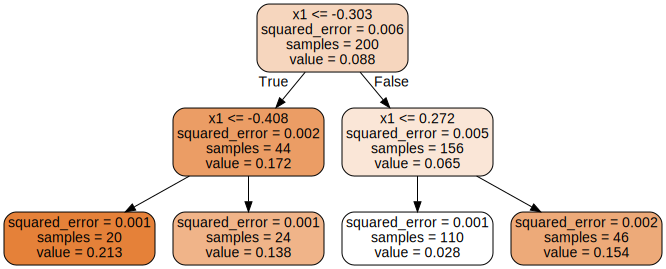

In [46]:
from sklearn.tree import export_graphviz

export_graphviz(tree_reg, out_file="iris_tree_reg.dot", feature_names=["x1"],
               rounded=True, filled=True)

from graphviz import Source

Source.from_file("iris_tree_reg.dot")

In [ ]:
#The CART algorithm works as described earlier, except that instead of trying to split
#the training set in a way that minimizes impurity, it now tries to split the training set in
#a way that minimizes the MSE. Equation 6-4 shows the cost function that the algorithm
#tries to minimize.


#Just like for classification tasks, decision trees are prone to overfitting when dealing
#with regression tasks. Without any regularization (i.e., using the default
#hyperparameters), you get the predictions on the left in Figure 6-6. These predictions
#are obviously overfitting the training set very badly. Just setting min_samples_leaf=10
#results in a much more reasonable model, represented on the right in Figure 6-6.


In [48]:
#Sensitivity to Axis Orientation
#Hopefully by now you are convinced that decision trees have a lot going for them: they are relatively easy
#to understand and interpret, simple to use, versatile, and powerful. However, they do have a few limitations.
#First, as you may have noticed, decision trees love orthogonal decision boundaries (all splits are perpendicular
#to an axis), which makes them sensitive to the data’s orientation. For example, Figure 6-7 shows a simple linearly
#separable dataset: on the left, a decision tree can split it easily, while on the right, after the dataset is
#rotated by 45°, the decision boundary looks unnecessarily convoluted. Although both decision trees fit the
#training set perfectly, it is very likely that the model on the right will not generalize well.

#One way to limit this problem is to scale the data, then apply a principal component analysis transformation. 
#We will look at PCA in detail in Chapter 8, but for now you only need to know that it rotates the data in a 
#way that reduces the correlation between the features, which often (not always) makes things easier for trees.

#Let’s create a small pipeline that scales the data and rotates it using PCA, then train a DecisionTreeClassifier
#on that data. Figure 6-8 shows the decision boundaries of that tree: as you can see, the rotation makes it
#possible to fit the dataset pretty well using only one feature, z1, which is a linear function of the
#original petal length and width. Here’s the code:


from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)



DecisionTreeClassifier(max_depth=2, random_state=42)

In [ ]:
#Decision Trees Have a High Variance
#More generally, the main issue with decision trees is that they have quite a high variance: small changes
#to the hyperparameters or to the data may produce very different models. In fact, since the training algorithm
#used by Scikit-Learn is stochastic —it randomly selects the set of features to evaluate at each node—even
#retraining the same decision tree on the exact same data may produce a very different model, such as the
#one represented in Figure 6-9 (unless you set the random_state hyperparameter). As you can see, it looks
#very different from the previous decision tree (Figure 6-2).


#Luckily, by averaging predictions over many trees, it’s possible to reduce variance significantly. 
#Such an ensemble of trees is called a random forest, and it’s one of the most powerful types of models
#available today, as you will see in the next chapter.


